# Simple synthetic test to compare Steepest Descent to Newton's method

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

## Using Gauss-Newton to impose smoothness


$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[ \mathbf{A}^T \mathbf{A} + \mu \mathbf{R}^T \mathbf{R} \right]^{-1} 
\left[ \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)] - \mu \mathbf{R}^T \mathbf{R}\mathbf{p}^k \right]
$$


Is there a difference between both methods? We've seen from the `moho-inversion-class.ipynb` notebook that the computation time is practically the same. If there is a difference, which is better?

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import multiprocessing
import cPickle as pickle
import numpy as np
import scipy as sp
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [3]:
from fatiando.inversion import Smoothness2D
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [5]:
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical, make_mesh, cross_validation

Get the number of cores in this computer to run the some things in parallel.

In [6]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


## Create a model and generate synthetic data

Define the computation grid.

In [7]:
shape = (51, 51)
# Make a regular grid inside an area
area = (10, 70, -50, 50)
grid_height = 50e3
lat, lon, h = gridder.regular(area, shape, z=grid_height)

In [8]:
reference = -30e3

In [9]:
relief = (
    -25e3 + 15e3*sp.special.erf((lon - 10)/20) # The general flow from continent to ocean
    - 15e3*utils.gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
    + 15e3*utils.gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
    - 10e3*utils.gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
    - 10e3*utils.gaussian2d(lat, lon, 10, 10, x0=30, y0=25)**2
    + 5e3*utils.gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15)
    )

In [10]:
model = make_mesh(area, shape, relief, reference)

In [11]:
density_contrast = 600
print("Using density contrast of {} kg.m^-3".format(density_contrast))
density = density_contrast*np.ones_like(relief)
# The density contrast is negative if the relief is below the reference
density[relief < reference] *= -1
model.addprop('density', density)

Using density contrast of 600 kg.m^-3


In [12]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='c')

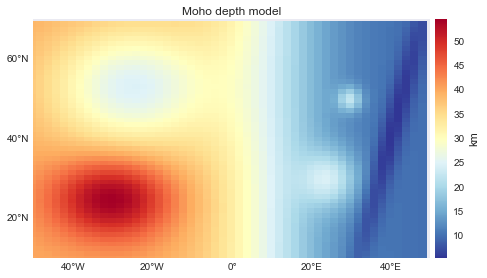

In [13]:
x, y = bm(model.lon, model.lat)
data = -0.001*model.relief.reshape(model.shape)
plt.figure(figsize=(7, 3.5))
plt.title("Moho depth model")
bm.pcolormesh(x, y, data, cmap='RdYlBu_r')
plt.colorbar(pad=0.01).set_label('km')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout(pad=0)

In [14]:
def plot_result_3d(moho, fname, show=False):
    scale = (1, 1, 50) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.reverse_lut = True
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [16636926.649261517, -1319122.234544111, 8149786.3791323639]
    scene.scene.camera.focal_point = [3084649.4693923225, 48848.433286546991, 3042445.3720120676]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [-0.3021359583205071, 0.3365830356365625, 0.89186642655244375]
    scene.scene.camera.clipping_range = [7555472.7244926561, 22961066.656610727]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    if show:
        myv.show()
    else:
        myv.mlab.close()
    return Image(filename=fname)    

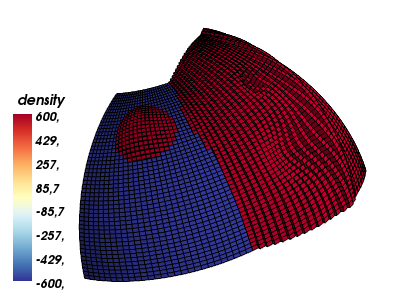

In [15]:
plot_result_3d(model, 'simple-synthetic-model.png', show=False)

Forward model the synthetic data on a regular grid at a constant height. Contaminate the data with pseudo-random Gaussian noise.

In [16]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 5, seed=0)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


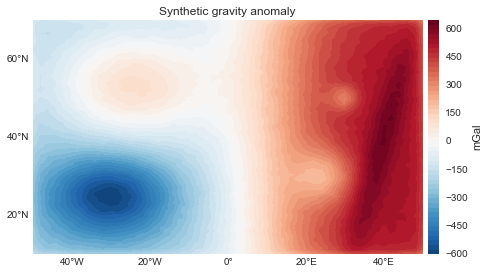

In [17]:
x, y = bm(lon, lat)
plt.figure(figsize=(7, 3.5))
plt.title('Synthetic gravity anomaly')
ranges = np.abs([gz.max(), gz.min()]).max()
bm.contourf(lon, lat, gz, 50, cmap='RdBu_r', tri=True, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01).set_label('mGal')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout(pad=0)

## Define plotting functions

In [18]:
def plot_result_maps(solver):
    # Make plots of the data fit, the estimated Moho depth, and the difference 
    # with the true values.
    predicted = solver[0].predicted()
    residuals = solver[0].residuals()
    moho = solver.estimate_
    
    ranges = np.abs([gz.max(), gz.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, gz, shape, 25, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels, basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.6, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True)
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 3.5))
    plt.title("Estimated Moho depth using {}".format(solver.stats_['method']))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='RdYlBu_r')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)
    
    
    diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    ranges = np.abs([diff.max(), diff.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title("Difference between true and estimated")  
    bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)

In [19]:
def plot_cv(best, regul_params, scores, solver, log=True):    
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation for {}'.format(solver.stats_['method']))
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)

In [20]:
def plot_convergence(solver):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence of {}'.format(solver.stats_['method']))
    plt.plot(range(solver.stats_['iterations'] + 1), solver.stats_['objective'])
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.ylabel('Goal function')
    plt.tight_layout(pad=0)

## Inversion setup

In [21]:
# Make a mesh
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)
initial = np.ones(mesh.size)*(mesh.reference - 30e3)

In [22]:
misfit = MohoGravityInvSpherical(lat, lon, h, gz, mesh)
regul = Smoothness2D(mesh.shape)

## Cross-validation

I'll use cross-validation to determine the optimal value of the regularization parameter.
The way this works is:

1. Create a separate dataset that will be used to check our solutions (the test dataset $\mathbf{d}_{test}$)
2. Run the inversion on the observed data for each value of the regularization parameter
3. For each solution, calculate the predicted data for the **test dataset** ($\mathbf{d}'_{test}$ and the corresponding Mean Square Error (MSE) error.
4. Choose the solution with the smallest MSE value for the test dataset.

The MSE is

$$
MSE = \dfrac{[\mathbf{d}_{test} - \mathbf{d}'_{test}]^T[\mathbf{d}_{test} - \mathbf{d}'_{test}]}{N_{test}}
$$

First, create the test data. I'll use a regular grid as well but at a lower height. This could be obtained from the same spherical harmonic model.

In [23]:
test_shape = [int(s*1.2) for s in shape]
print(test_shape)
test_lat, test_lon, test_h = gridder.regular(area, test_shape, z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_data = utils.contaminate(test_data, 5, seed=10)  # Use a different seed to get independent errors

[61, 61]


Make a solver using the original mesh but with the test data (ignore the warning).

In [24]:
test_set = MohoGravityInvSpherical(test_lat, test_lon, test_h, test_data, mesh)

moho.py:71: RuntimeWarning: The mesh size (2601) is different from the data size (3721). The mesh elements should be below each data point. Make sure you know what you're doing.
  warnings.warn(msg, RuntimeWarning)


## Steepest Descent

In [25]:
regul_params = np.logspace(-6, -1, 12)
regul_params

array([  1.00000000e-06,   2.84803587e-06,   8.11130831e-06,
         2.31012970e-05,   6.57933225e-05,   1.87381742e-04,
         5.33669923e-04,   1.51991108e-03,   4.32876128e-03,
         1.23284674e-02,   3.51119173e-02,   1.00000000e-01])

In [26]:
steep_config = dict(method='steepest', initial=initial, tol=0.1, maxit=10, linesearch=False)

In [27]:
%time results_steep = cross_validation(misfit, regul, regul_params, steep_config, test_set, njobs=ncpu)

CPU times: user 243 ms, sys: 85.1 ms, total: 328 ms
Wall time: 6min 58s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not

In [28]:
with open('synthetic-steepest-vs-newton.steepest.pickle', 'w') as f:
    pickle.dump(results_steep, f)

Uncomment and use the cell below to load the saved results. This will save time when making and tweaking plots (so we don't need to do the long computation again).

In [29]:
#with open('synthetic-steepest-vs-newton.steepest.pickle') as f:
#    results_steep = pickle.load(f)

Unpack the results and plot the cross-validation data.

In [30]:
best, steep, scores, solvers = results_steep

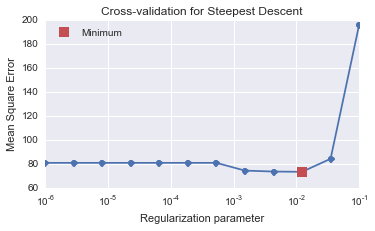

In [31]:
plot_cv(best, regul_params, scores, steep, log=False)

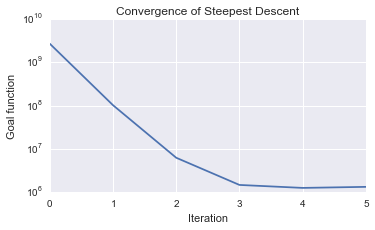

In [32]:
plot_convergence(steep)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


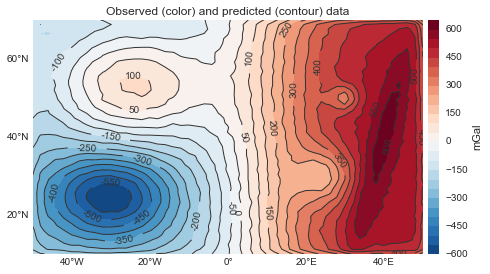

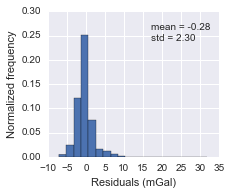

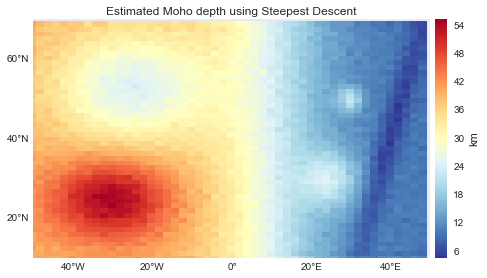

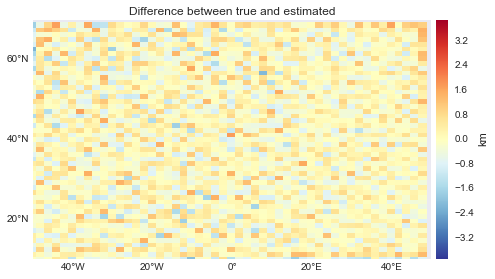

In [33]:
plot_result_maps(steep)

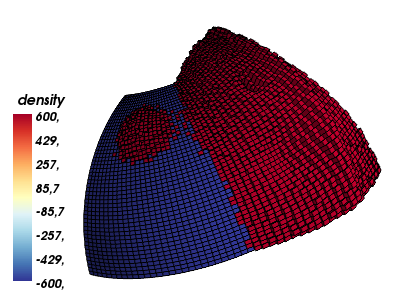

In [34]:
plot_result_3d(steep.estimate_, 'simple-synthetic-steepest.png')

**Notice that the solution is still not properly smooth.** 
So it seems that using only the gradient of the smoothness regularization with Steepest Descent is not enough to fully smooth the solution. The results in Santos et al 2015 are smooth, though. Maybe that's because they start out with a regularized solution from the start.

## Newton

In [35]:
regul_params = np.logspace(-6, -1, 12)
regul_params

array([  1.00000000e-06,   2.84803587e-06,   8.11130831e-06,
         2.31012970e-05,   6.57933225e-05,   1.87381742e-04,
         5.33669923e-04,   1.51991108e-03,   4.32876128e-03,
         1.23284674e-02,   3.51119173e-02,   1.00000000e-01])

In [36]:
newton_config = dict(method='newton', initial=initial, tol=0.1, maxit=10)

In [37]:
%time results_newton = cross_validation(misfit, regul, regul_params, newton_config, test_set, njobs=ncpu)

CPU times: user 268 ms, sys: 77.5 ms, total: 346 ms
Wall time: 7min 34s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not

In [38]:
with open('synthetic-steepest-vs-newton.newton.pickle', 'w') as f:
    pickle.dump(results_newton, f)

Uncomment and use the cell below to load the saved results. This will save time when making and tweaking plots (so we don't need to do the long computation again).

In [39]:
#with open('synthetic-steepest-vs-newton.newton.pickle') as f:
#    results_newton = pickle.load(f)

In [40]:
best, newton, scores, solvers = results_newton

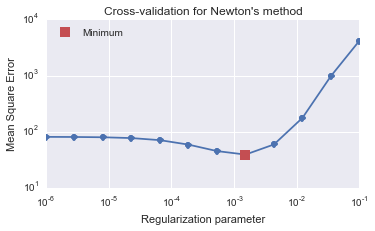

In [41]:
plot_cv(best, regul_params, scores, newton)

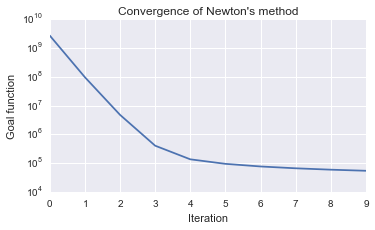

In [42]:
plot_convergence(newton)

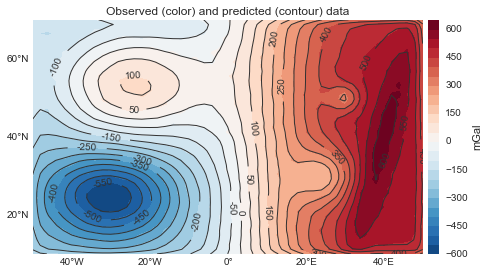

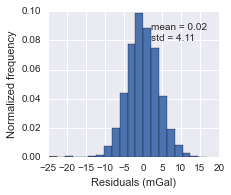

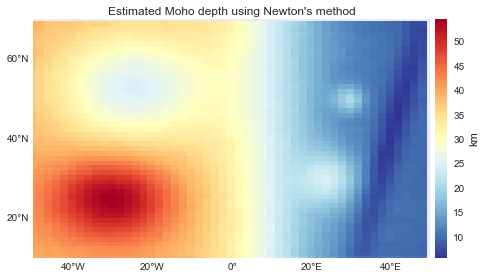

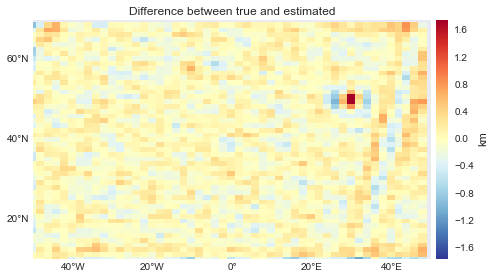

In [43]:
plot_result_maps(newton)

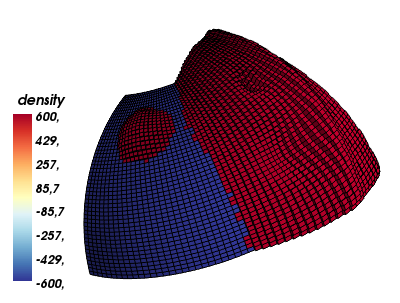

In [44]:
plot_result_3d(newton.estimate_, 'simple-synthetic-newton.png')